In [288]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [289]:
## meta data
data=[]
with open('bbc-news-data.csv','r') as f:
  for row in csv.reader(f):
    data.append(row[0].split('\t'))


## content of data
data_cont=[]
with open('bbc-news-data.csv','r') as f:
  for row in csv.reader(f):
    data_cont.append(row[1:])   

col=data[0]
df = pd.DataFrame(data[1:],columns=col) 


for i in range(len(data)):
  data_cont[i].insert(0, data[i][-1])
    


In [290]:
del df['content']
df['content_all']=data_cont[1:]
#df=df['category','file','title','content_all']


In [291]:
df['merged']=''
for i in range(df.shape[0]):
  df.merged[i] = ' '.join(df.iloc[i][3])

In [292]:
df.merged=df.merged.apply(lambda x: x.lower())
df.merged=df.merged.apply(lambda x: x.split())


In [293]:
def preprocess(value):
  return [x for x in value if x not in stopwords]
df.merged=df.merged.apply(lambda x: preprocess(x))


0       [quarterly, profits, us, media, giant, timewar...
1       [owners, embattled, russian, oil, giant, yukos...
2       [british, airways, blamed, high, fuel, prices,...
3       [shares, uk, drinks, food, firm, allied, domec...
4       [japan's, economy, teetered, brink, technical,...
                              ...                        
1618    [internet, tv, talked, since, start, web, know...
1619    [thousands, products, tens, thousands, visitor...
1620    [making, games, future, consoles, will, requir...
1621    [new, european, directive, put, software, writ...
1622    [man, making, sure, us, computer, networks, sa...
Name: merged, Length: 1623, dtype: object

In [296]:

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


In [308]:
vocab_size = 100000
embedding_dim = 16
max_length = 1000 # Expected max_len is 120 a few cells down.
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

In [314]:
training_portion=0.8
train_set=df.sample(int(df.shape[0]*training_portion))
eval_set=df.sample(int(df.shape[0]*(1-training_portion)))

In [315]:
tokenizer_text =Tokenizer(oov_token=oov_tok)
tokenizer_text.fit_on_texts(df.merged)
word_index = tokenizer_text.word_index

train_sequences = tokenizer_text.texts_to_sequences(train_set.merged)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


eval_sequences = tokenizer_text.texts_to_sequences(eval_set.merged)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [316]:
tokenizer_label =Tokenizer()
tokenizer_label.fit_on_texts(df.category)
label_index = tokenizer_text.word_index

train_labels = np.array(tokenizer_label.texts_to_sequences(train_set.category))


eval_labels = np.array(tokenizer_label.texts_to_sequences(eval_set.category))


In [317]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 16)          1600000   
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 150       
Total params: 1,600,558
Trainable params: 1,600,558
Non-trainable params: 0
_________________________________________________________________


In [318]:
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(eval_padded, eval_labels))

Epoch 1/30
41/41 [==============================] - 1s 24ms/step - loss: 1.7799 - accuracy: 0.2132 - val_loss: 1.7461 - val_accuracy: 0.2469
Epoch 2/30
41/41 [==============================] - 1s 20ms/step - loss: 1.7348 - accuracy: 0.2258 - val_loss: 1.6881 - val_accuracy: 0.2716
Epoch 3/30
41/41 [==============================] - 1s 20ms/step - loss: 1.6777 - accuracy: 0.2691 - val_loss: 1.6110 - val_accuracy: 0.3364
Epoch 4/30
41/41 [==============================] - 1s 19ms/step - loss: 1.5946 - accuracy: 0.3211 - val_loss: 1.5405 - val_accuracy: 0.3272
Epoch 5/30
41/41 [==============================] - 1s 20ms/step - loss: 1.5453 - accuracy: 0.3263 - val_loss: 1.4841 - val_accuracy: 0.3611
Epoch 6/30
41/41 [==============================] - 1s 20ms/step - loss: 1.4711 - accuracy: 0.3666 - val_loss: 1.4176 - val_accuracy: 0.4383
Epoch 7/30
41/41 [==============================] - 1s 20ms/step - loss: 1.3780 - accuracy: 0.4821 - val_loss: 1.3398 - val_accuracy: 0.5247
Epoch 8/30
41

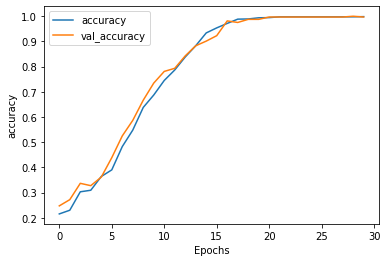

In [321]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_'+'accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_'+'accuracy'])
plt.show()


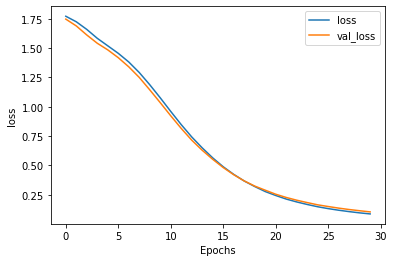

In [322]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_'+'loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_'+'loss'])
plt.show()